<a href="https://colab.research.google.com/github/m3llad0/TC3007C/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
from zipfile import ZipFile
import numpy as np
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization , MaxPooling2D, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow

In [30]:
#Download the dataset from kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d mohamedhanyyy/chest-ctscan-images

with ZipFile('chest-ctscan-images.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

!rm chest-ctscan-images.zip


 95% 113M/119M [00:00<00:00, 301MB/s] 
100% 119M/119M [00:00<00:00, 294MB/s]


In [31]:
!mv Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib Data/train/adenocarcinoma

!mv Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa Data/train/large.cell.carcinoma

!mv Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa Data/train/squamous.cell.carcinoma

!mv Data/valid/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib Data/valid/adenocarcinoma

!mv Data/valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa Data/valid/large.cell.carcinoma

!mv Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa Data/valid/squamous.cell.carcinoma

## Preprocesamiento de datos



In [32]:
!mkdir CombinedData
!mkdir CombinedData/adenocarcinoma
!mkdir CombinedData/large.cell.carcinoma
!mkdir CombinedData/normal
!mkdir CombinedData/squamous.cell.carcinoma


!mv Data/train/adenocarcinoma/* CombinedData/adenocarcinoma/
!mv Data/train/large.cell.carcinoma/* CombinedData/large.cell.carcinoma/
!mv Data/train/normal/* CombinedData/normal
!mv Data/train/squamous.cell.carcinoma/* CombinedData/squamous.cell.carcinoma/

!mv Data/test/adenocarcinoma/* CombinedData/adenocarcinoma/
!mv Data/test/large.cell.carcinoma/* CombinedData/large.cell.carcinoma/
!mv Data/test/normal/* CombinedData/normal
!mv Data/test/squamous.cell.carcinoma/* CombinedData/squamous.cell.carcinoma/

!mv Data/valid/adenocarcinoma/* CombinedData/adenocarcinoma/
!mv Data/valid/large.cell.carcinoma/* CombinedData/large.cell.carcinoma/
!mv Data/valid/normal/* CombinedData/normal
!mv Data/valid/squamous.cell.carcinoma/* CombinedData/squamous.cell.carcinoma/

In [33]:
from sklearn.model_selection import train_test_split
import os
import shutil

# Directorio raíz que contiene todas las imágenes combinadas
combined_data_dir = 'CombinedData'

# Directorio de salida para almacenar los conjuntos de train, test y valid
output_dir = 'Data'
os.makedirs(output_dir, exist_ok=True)

# Lista de clases
classes = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']

# Proporciones de división de datos
train_ratio = 0.7
test_ratio = 0.2
validation_ratio = 0.1

# Iterar sobre cada clase
for class_name in classes:
    class_dir = os.path.join(combined_data_dir, class_name)
    images = os.listdir(class_dir)

    # Dividir las imágenes en conjuntos de train, test y valid
    train_images, test_images = train_test_split(images, test_size=(1 - train_ratio), random_state=42)
    test_images, validation_images = train_test_split(test_images, test_size=(validation_ratio / (1 - train_ratio)), random_state=42)

    # Crear directorios de salida para train, test y valid
    train_dir = os.path.join(output_dir, 'train', class_name)
    test_dir = os.path.join(output_dir, 'test', class_name)
    validation_dir = os.path.join(output_dir, 'valid', class_name)

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    os.makedirs(validation_dir, exist_ok=True)

    # Mover imágenes a los directorios correspondientes
    for image in train_images:
        shutil.move(os.path.join(class_dir, image), os.path.join(train_dir, image))
    for image in test_images:
        shutil.move(os.path.join(class_dir, image), os.path.join(test_dir, image))
    for image in validation_images:
        shutil.move(os.path.join(class_dir, image), os.path.join(validation_dir, image))


In [34]:
train_data_dir = './Data/train'
test_data_dir = './Data/test'
validation_data_dir = './Data/valid'

In [35]:
input_size = (224, 224)

training_datagen = ImageDataGenerator(dtype='float32',)
test_datagen = ImageDataGenerator( dtype='float32')
validation_datagen = ImageDataGenerator( dtype='float32')

# Load and preprocess training data
train_generator = training_datagen.flow_from_directory(
    train_data_dir,
    target_size=input_size,
    batch_size=32,
    class_mode='categorical')

# Load and preprocess testing data
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=input_size,
    batch_size=32,
    class_mode='categorical')

# Load and preprocess validation data
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=input_size,
    batch_size=32,
    class_mode='categorical')

Found 629 images belonging to 4 classes.
Found 179 images belonging to 4 classes.
Found 92 images belonging to 4 classes.


## Construcción del modelo

El modelo se construyó utilizando como base


In [36]:
from tensorflow.keras.applications import ResNet50
base_model = ResNet50(include_top=False,
                      pooling='avg',
                      weights='imagenet',
                      input_shape = (224, 224, 3))

for layer in base_model.layers:
  if 'conv5' not in layer.name:
    layer.trainable = False

In [37]:
model = tensorflow.keras.models.Sequential()
num_classes = len(train_generator.class_indices)

model.add(base_model)
model.add(Dropout(0.4))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

In [38]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [39]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(verbose = 1,
                               patience = 5,
                               restore_best_weights = True)
epochs = 100
history = model.fit(
    train_generator,
    verbose = 1,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping])



Epoch 1/100
20/20 [==============================] - 28s 450ms/step - loss: 1.0428 - accuracy: 0.6645 - val_loss: 524.1289 - val_accuracy: 0.1739
Epoch 2/100
20/20 [==============================] - 4s 220ms/step - loss: 0.2388 - accuracy: 0.9110 - val_loss: 150.2748 - val_accuracy: 0.1957
Epoch 3/100
20/20 [==============================] - 5s 254ms/step - loss: 0.1025 - accuracy: 0.9666 - val_loss: 14.4470 - val_accuracy: 0.4891
Epoch 4/100
20/20 [==============================] - 5s 250ms/step - loss: 0.0392 - accuracy: 0.9873 - val_loss: 1.9932 - val_accuracy: 0.8261
Epoch 5/100
20/20 [==============================] - 4s 220ms/step - loss: 0.0299 - accuracy: 0.9921 - val_loss: 1.4997 - val_accuracy: 0.7391
Epoch 6/100
20/20 [==============================] - 5s 243ms/step - loss: 0.0265 - accuracy: 0.9889 - val_loss: 0.1064 - val_accuracy: 0.9565
Epoch 7/100
20/20 [==============================] - 5s 233ms/step - loss: 0.0222 - accuracy: 0.9936 - val_loss: 0.2595 - val_accuracy: 

In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_1 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 4)                 8196      
                                                      

In [41]:
model.evaluate(test_generator)

6/6 [==============================] - 2s 314ms/step - loss: 0.1402 - accuracy: 0.9553


[0.1401968002319336, 0.9553072452545166]

Text(0.5, 1.0, 'Training and Validation Accuracy over Epochs')

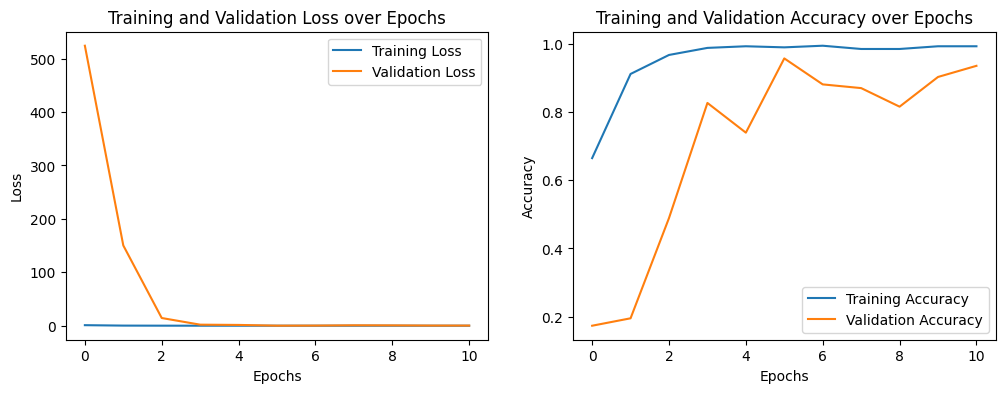

In [42]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy over Epochs')

6/6 [==============================] - 2s 169ms/step


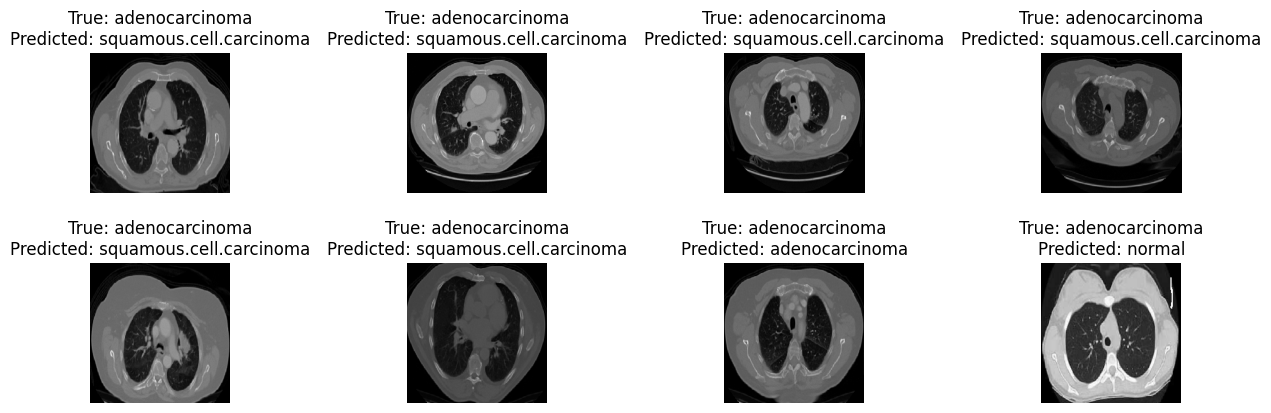

In [43]:
sample_images, _ = next(test_generator)

# Generar predicciones en el conjunto de datos de prueba
predictions = model.predict(test_generator)

# Obtener las etiquetas reales y predichas
true_labels = test_generator.classes
predicted_labels = np.argmax(predictions, axis=1)

class_labels = list(test_generator.class_indices.keys())

# Mostrar las imágenes con etiquetas reales y predichas
plt.figure(figsize=(15, 10))
for i in range(8):  # Muestra las primeras 16 imágenes
    plt.subplot(4, 4, i + 1)
    plt.imshow(sample_images[i]/255)
    plt.title(f"True: {class_labels[true_labels[i]]}\nPredicted: {class_labels[predicted_labels[i]]}")
    plt.axis('off')

    plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Ajusta el espacio vertical y horizontal entre subgráficos


[[28  8 11 18]
 [ 8  6  9  9]
 [14  6  1 11]
 [19  9 10 12]]


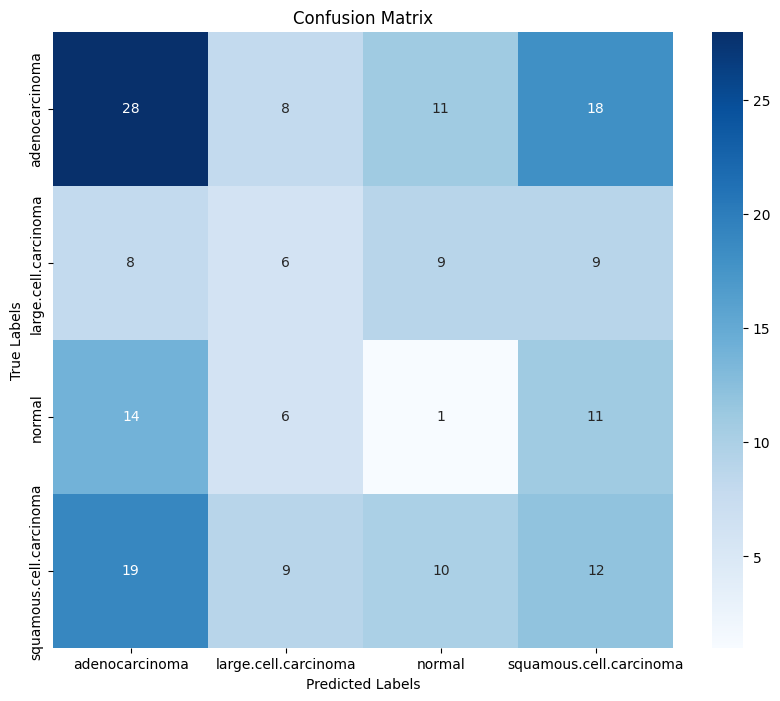

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generar la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)
# Obtener etiquetas de clases para visualización
class_labels = list(test_generator.class_indices.keys())

# Crear un mapa de calor para visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Ajuste de modelo

In [76]:
base_model_ = ResNet50(include_top=False,
                      pooling='avg',
                      weights='imagenet',
                      input_shape = (224, 224, 3))

for layer in base_model.layers:
  if 'conv5' not in layer.name:
    layer.trainable = False

In [96]:
model_ajusted = tensorflow.keras.models.Sequential()
num_classes = len(train_generator.class_indices)

model_ajusted.add(base_model_)
model_ajusted.add(Dropout(0.5))
model_ajusted.add(Flatten())
model_ajusted.add(BatchNormalization())
model_ajusted.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))  # Puedes ajustar el número de unidades según lo necesario
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.5))
model_ajusted.add(Dense(num_classes, activation='softmax'))

In [97]:
model_ajusted.compile(loss='categorical_crossentropy',
              optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.00001),
              metrics=['accuracy'])

In [98]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor = 'val_loss',
                              verbose = 1,
                               patience = 2,)


checkpoint = ModelCheckpoint(filepath='./transfer_model.hdf5',
                               monitor='val_loss',
                               verbose = 1,
                               save_best_only=True)
epochs = 100
history_ajusted = model_ajusted.fit(
    train_generator,
    verbose = 1,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[checkpoint])



Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 2.0695 - accuracy: 0.3132
Epoch 1: val_loss improved from inf to 1.03483, saving model to ./transfer_model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 44s 722ms/step - loss: 2.0695 - accuracy: 0.3132 - val_loss: 1.0348 - val_accuracy: 0.5870
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 1.2820 - accuracy: 0.5246
Epoch 2: val_loss improved from 1.03483 to 0.81261, saving model to ./transfer_model.hdf5
20/20 [==============================] - 13s 650ms/step - loss: 1.2820 - accuracy: 0.5246 - val_loss: 0.8126 - val_accuracy: 0.6957
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 0.8494 - accuracy: 0.6582
Epoch 3: val_loss improved from 0.81261 to 0.68995, saving model to ./transfer_model.hdf5
20/20 [==============================] - 10s 504ms/step - loss: 0.8494 - accuracy: 0.6582 - val_loss: 0.6899 - val_accuracy: 0.7500
Epoch 4/100
20/20 [==============================] - ETA: 0s - loss: 0.6780 - accuracy: 0.7250
Epoch 4: val_loss improved from 0.68995 to 0.60331, saving model to ./transfer_model.hdf5
20/20 [==============================] - 13s 657m

In [99]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_1 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 4)                 8196      
                                                      

In [100]:
model_ajusted.evaluate(test_generator)

6/6 [==============================] - 2s 211ms/step - loss: 0.1308 - accuracy: 0.9721


[0.13077348470687866, 0.9720670580863953]

Text(0.5, 1.0, 'Training and Validation Accuracy over Epochs')

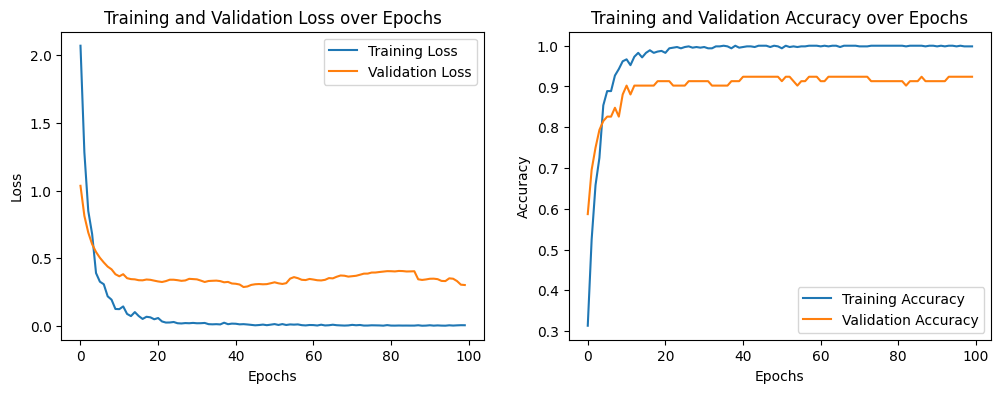

In [101]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_ajusted.history['loss'], label='Training Loss')
plt.plot(history_ajusted.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history_ajusted.history['accuracy'], label='Training Accuracy')
plt.plot(history_ajusted.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy over Epochs')

6/6 [==============================] - 2s 160ms/step


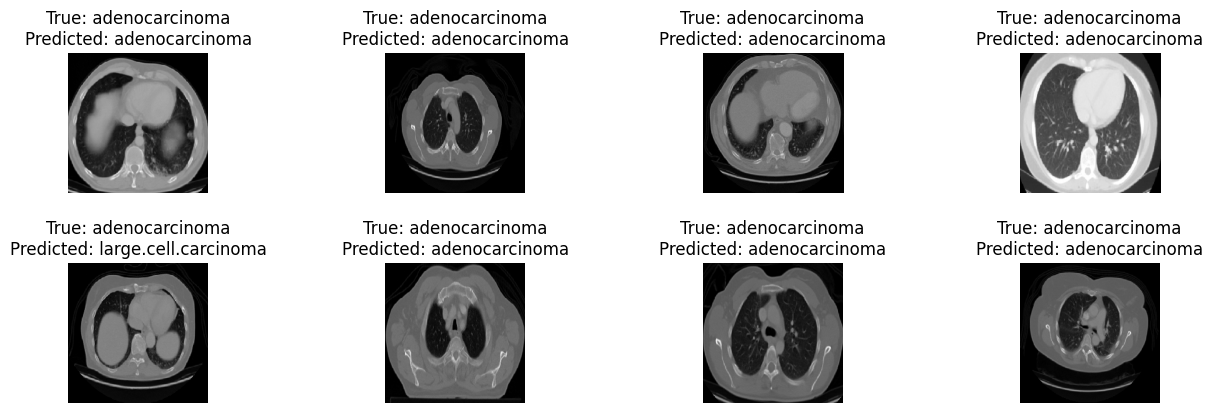

In [102]:
# sample_images, _ = next(test_generator)

# # Generar predicciones en el conjunto de datos de prueba
# predictions = model_ajusted.predict(test_generator)

# # Obtener las etiquetas reales y predichas
# true_labels = test_generator.classes
# predicted_labels = np.argmax(predictions, axis=1)

# class_labels = list(test_generator.class_indices.keys())

# # Mostrar las imágenes con etiquetas reales y predichas
# plt.figure(figsize=(15, 10))
# for i in range(8):  # Muestra las primeras 16 imágenes
#     plt.subplot(4, 4, i + 1)
#     plt.imshow(sample_images[i]/255)
#     plt.title(f"True: {class_labels[true_labels[i]]}\nPredicted: {class_labels[predicted_labels[i]]}")
#     plt.axis('off')

#     plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Ajusta el espacio vertical y horizontal entre subgráficos


6/6 [==============================] - 3s 442ms/step
[[65  0  0  0]
 [ 1 30  1  0]
 [ 0  0 32  0]
 [ 3  0  0 47]]


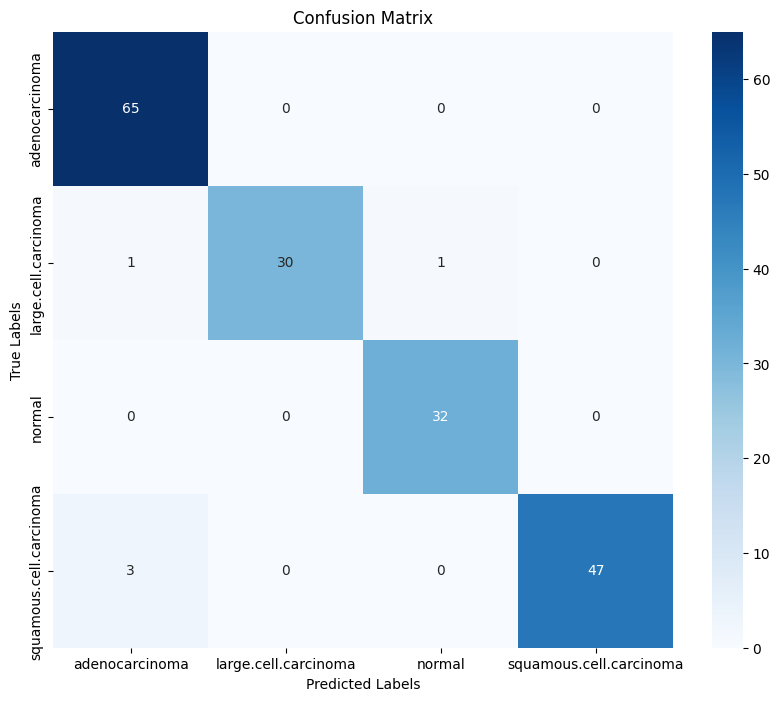

In [104]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

true_labels = []
num_batches = len(test_generator)

for i in range(num_batches):
    _, labels = test_generator[i]
    true_labels.extend(np.argmax(labels, axis=1))

true_labels = np.array(true_labels)

predictions = model_ajusted.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Generar la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)
# Obtener etiquetas de clases para visualización
class_labels = list(test_generator.class_indices.keys())

# Crear un mapa de calor para visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()